# 1、背景描述

在一个 Stroop （斯特鲁普）任务中，参与者得到了一列文字，每个文字都用一种油墨颜色展示。参与者的任务是将文字的打印颜色大声说出来。这项任务有两个条件：一致文字条件，和不一致文字条件。在一致文字条件中，显示的文字是与它们的打印颜色匹配的颜色词，如“红色”、“蓝色”。在不一致文字条件中，显示的文字是与它们的打印颜色不匹配的颜色词，如“紫色”、“橙色”。在每个情况中，我们将计量说出同等大小的列表中的墨色名称的时间。每位参与者必须全部完成并记录每种条件下使用的时间。

# 2、问题处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2.1数据评估和处理

In [2]:
# 查看数据集的基本信息
df = pd.read_csv('stroopdata.csv')
df.head()

,Congruent,Incongruent
0,12.079,19.278
1,16.791,18.741
2,9.564,21.214
3,8.630,15.687
4,14.669,22.803


### 2.1.1 数据类型

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
Congruent      24 non-null float64
Incongruent    24 non-null float64
dtypes: float64(2)
memory usage: 456.0 bytes


小结：类型均为 float

### 2.1.2 检查是否有缺失值

In [4]:
df.isnull().sum()

Congruent      0
Incongruent    0
dtype: int64

小结：无缺失值

### 2.1.3 检查数据是否冗余

In [5]:
sum(df.duplicated())

0

小结：数据无冗余

### 2.1.4 检查数据是否存在异常值

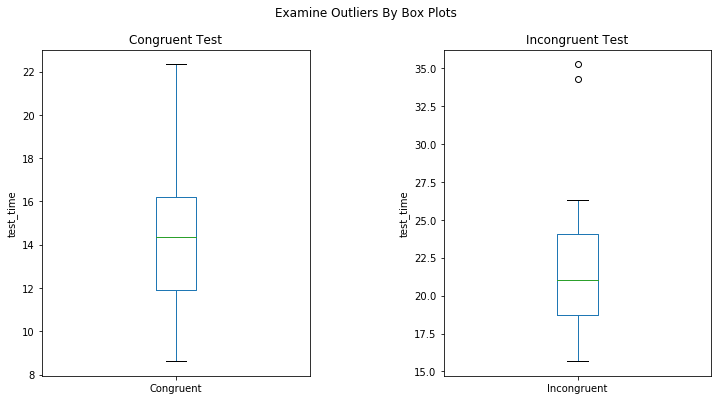

In [6]:
# 查看箱线图
fig,axes = plt.subplots(1,2,figsize=(12,6))

axes[0].set_ylabel('test_time')
axes[1].set_ylabel('test_time')

axes[0].set_title('Congruent Test')
axes[1].set_title('Incongruent Test')

fig.suptitle('Examine Outliers By Box Plots')
fig.subplots_adjust(wspace=0.5)

df.Congruent.plot(ax=axes[0], kind='box')
df.Incongruent.plot(ax=axes[1], kind='box')

plt.show();

小结：可以看到Incongruent以上存在两个异常值，这里，我选择剔除掉

In [7]:
# 查看异常值所在行
df_clean = df.copy(deep=True) # 备份df数据
df_clean.sort_values(['Incongruent'],ascending=False).head() # 查看异常值所在行，由于只有两个，使用head()

,Congruent,Incongruent
14,18.200,35.255
19,12.369,34.288
9,14.480,26.282
16,18.495,25.139
6,14.692,24.572


In [8]:
# 这里我们通过以上的Incongruent Test 图，也可看出，异常值是大于30.0的，
# 可以直接筛选
df[df.Incongruent>30.0]

,Congruent,Incongruent
14,18.200,35.255
19,12.369,34.288


#### 可以看出异常值是在index=14 和index=19这两个位置

In [9]:
df_clean.drop([14, 19],inplace=True) # 剔除异常值所在行
df_clean.sort_values(['Incongruent'],ascending=False)

,Congruent,Incongruent
9,14.480,26.282
16,18.495,25.139
6,14.692,24.572
10,22.328,24.524
20,12.944,23.894
4,14.669,22.803
15,12.130,22.158
22,19.710,22.058
2,9.564,21.214
23,16.004,21.157


## 2.2 假设检验&计算过程

### 2.2.1 自变量与因变量

自变量：文字条件（文字与文字颜色一致和不一致两种条件）

因变量：参与者在对应文字条件下，完成测试所用的时间

### 2.2.2假设

__文字描述__：

零假设（$H_0$）：受试者在两种文字条件下完成测试所用的时间没有显著差异

备用假设（$H_A$）：受试者在两种文字条件下完成测试所用的时间有显著差异

__数学描述__：

$H_0$:μ1=μ2 

$H_A$:μ1≠μ2 

注： 
>μ1 代表在文字与颜色一致条件(Congruent)下，受试者完成测试所用时间的总体均值

>μ2 代表在文字与颜色不一致条件(Incongruent)下，受试者完成测试所用时间的总体均值

In [10]:
# 增添新列，Congruent 与 Incongruent 的差值列，记为 xd
df_clean['xd'] = df_clean.Congruent - df_clean.Incongruent
df_clean.head()

,Congruent,Incongruent,xd
0,12.079,19.278,-7.199
1,16.791,18.741,-1.950
2,9.564,21.214,-11.650
3,8.630,15.687,-7.057
4,14.669,22.803,-8.134


### 2.2.3检验方式

基于以上假设，由于总体参数未知，选取t检验，这里是探究的是两种条件下总体均值是否有显著差异（事先不知道差异方向），故选用双尾t检验

取α= 0.05

__t检验前提条件是否满足？__

1:自变量有两种取值?
>此样本为相依样本，每组自变量是两种不同条件，条件满足

2：连续因变量?
>这里因为数据只有24组，初看测试时间是离散的，但是当数据量足够大时，测试时间确实是在某个范围，在（0，max_value）中连续分布的，条件满足。
(这里max_value,我是指测试总体所得到的最大测试时间)

3：样本中每组配对的差值相互独立?
>测试者之间是相互独立的，条件满足

4：样本近似接近正态分布?
>可以通过核密度曲线看出样本近似呈正态分布，条件满足

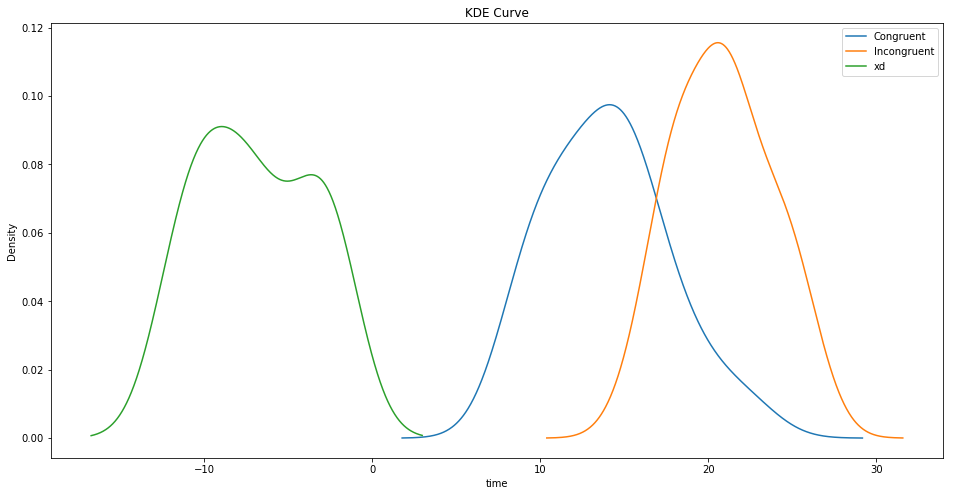

In [11]:
# 核密度曲线
df_clean.plot(kind='kde',figsize=(16,8))
plt.title('KDE Curve')
plt.xlabel('time');

### 2.2.4使用公式

### 已经确定为t检验，且处理对象为相依样本，使用公式如下
### t值

### $t_{statistic}= \frac{MD}{SEM}$
>t 统计量

>### $MD = \bar{X}-\bar{Y}$
>> X和Y数据均值差异

>> 这里X和Y分别对应数据中的一致条件和不一致条件所耗费时间

>### $SEM = \frac{SD}{\sqrt{n}}$

>> X和Y数据差值的样本偏差

>>### $SD = \sqrt{\frac{\sum_{i=1}^n\left[\left(x_i-y_i\right) - MD\right]^2}{n-1}}$

## $t_{critical}$ 
>t 临界值
>#### 需要根据自由度DF 和 $\alpha$ 查t分布表
>>DF = n - 1

>>这里取$\alpha = 0.5$

### 几个效应量

### $ CI = (MD - ME, MD + ME )$
>置信区间
>### $ME = t_{critical}\frac{SD}{\sqrt{n}}$
>>误差范围


### $ Cohen's \ d = \frac{MD}{SD}$

### $r^2 = \frac{t_{statistic}^2}{t_{statistic}^2 + DF}$

### 2.2.5描述性统计结果

In [12]:
# 查看描述性统计结果
df_clean.describe()

,Congruent,Incongruent,xd
count,22.000000,22.000000,22.000000
mean,13.939000,20.856318,-6.917318
std,3.592773,2.876923,3.400562
min,8.630000,15.687000,-11.802000
25%,11.527750,18.668250,-9.857500
50%,14.356500,20.820000,-7.128000
75%,15.827500,22.641750,-3.482500
max,22.328000,26.282000,-1.950000


In [13]:
# 这里我先定义以下变量，方便后面计算使用

SD = df_clean.xd.std(ddof=1)         # Congruent与Incongruent的差异（xd）的标准误差
x1_bar = df_clean.Congruent.mean()   # Congruent列数据均值
x2_bar = df_clean.Incongruent.mean() # Incongruent列数据均值
x_bar_d = x1_bar - x2_bar            # Congruent与Incongruent列数据均值差异
x1_bar,x2_bar

(13.939, 20.85631818181818)

In [14]:
# 注意：std上描述的是样本误差，非总体标准差,可以通过以下验证
df_clean['Congruent'].std(ddof=1),df_clean['Incongruent'].std(ddof=1)

(3.5927730104700335, 2.8769225023304994)

### 2.2.6推论性统计结果

In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 23
Data columns (total 3 columns):
Congruent      22 non-null float64
Incongruent    22 non-null float64
xd             22 non-null float64
dtypes: float64(3)
memory usage: 704.0 bytes


#### t 临界值

In [16]:
df_clean.shape

(22, 3)

In [17]:
#这里取的是 α= 0.5，双尾检验下的部分t临界值

# 因为前面我筛选掉了2行数据，那么实际数据只有22行，对应自由度 DF = 21
# 如果不剔除数据，那么，应该取DF = 23
# 这里，考虑到以上两种，我做了个字典，方便（剔除/不剔除）调用
t_critical_values = {20:2.086,
                     21:2.080,
                     22:2.074,
                     23:2.069,
                     24:2.064}

In [18]:
n = df_clean.shape[0] # 样本数
DF = n - 1 # 自由度
t_critical = t_critical_values[DF] # t 临界值
DF,t_critical

(21, 2.08)

![t-table](t-table.jpg)

#### t 统计量

In [19]:
# 计算 t 统计量
t_statictic = (x1_bar - x2_bar)/(SD/n**0.5)
t_statictic

-9.54109990849218

小结：因为 t 统计量已经超过这个t 临界值，位于临界区内，
所以拒绝零假设，这意味着，Congruent和Incongruent测试下
所用时间是具有显著性差异的

#### Cohen’s d

In [20]:
x_bar_d/SD

-2.034169335310982

反应出，样本差异的均值距离大约2个样本偏差

### $r^2$

In [21]:
t = t_statictic
r_square = t**2/(t**2+DF)
r_square

0.8125545390373136

In [22]:
r_pert = r_square * 100
print('小结：可以看出,两者之间的 %.2f' % r_pert + '% 差异是由于文字颜色不一致的情况所致')

小结：可以看出,两者之间的 81.26% 差异是由于文字颜色不一致的情况所致


#### 误差范围（margin of error）

In [23]:
ME = t_critical * (SD/n**0.5) # 误差范围 
ME

1.5080045231866372

#### 置信区间（confidence interval）

In [24]:
CI = (x_bar_d-ME, x_bar_d+ME) # 这里我用元组来表示置信区间的上下限
CI

(-8.425322705004819, -5.409313658631545)

In [25]:
print('小结：可以看出，平均下来，Congruent组的反应时间要比Incongruent组的快 %.1f 到 %.1f 秒' % (-CI[1],-CI[0]))

小结：可以看出，平均下来，Congruent组的反应时间要比Incongruent组的快 5.4 到 8.4 秒


#### P值

查看对应P值
参数选择为
>t = -9.54

>DF = 21

https://www.graphpad.com/quickcalcs/pValue1/

网站对应结果如下

t = -9.54   DF=21   
   The two-tailed P value is less than 0.0001 

小结：由于 P < 0.0001 ，即 P < α，故认为 Congruent 和 Incongruent 两种测试是存在显著差异的

### 2.2.7几个分布图

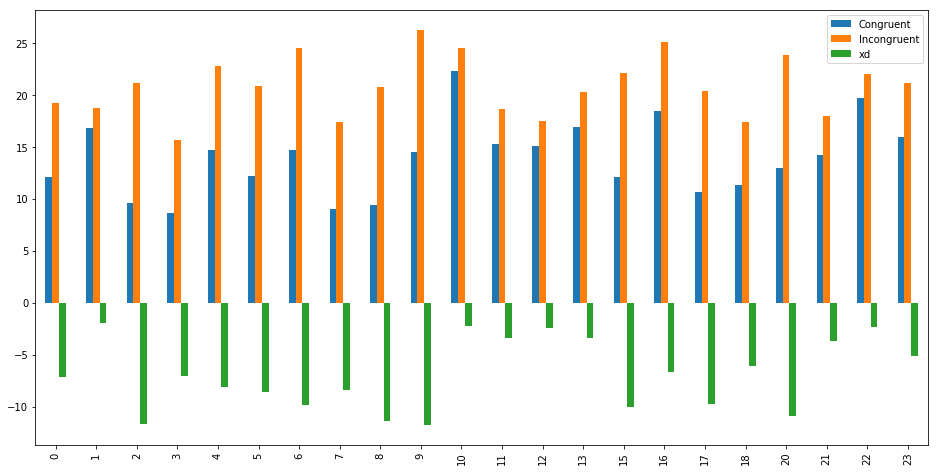

In [26]:
# 查看柱形图
df_clean.plot(kind='bar',figsize=(16,8));

小结：Incongruent条件下所花费时间均高于Congruent

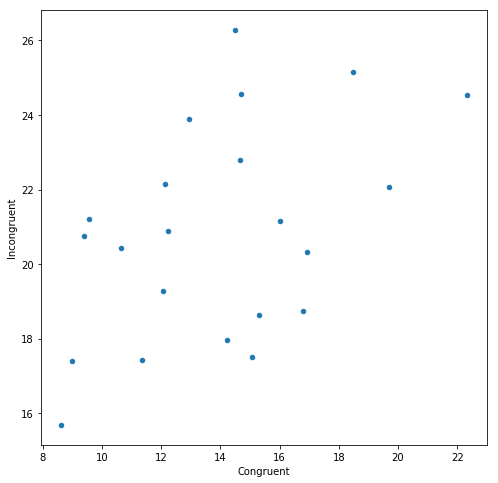

In [27]:
# 查看散点图
df_clean.plot('Congruent','Incongruent',kind='scatter',figsize=(8,8));

In [28]:
# 计算相关系数（皮尔逊）
corr = df_clean.corr()
corr

,Congruent,Incongruent,xd
Congruent,1.000000,0.465401,0.662788
Incongruent,0.465401,1.000000,-0.354307
xd,0.662788,-0.354307,1.000000


In [29]:
print('小结：可以看出，Incongruent与Congruent所花费时间两者呈正相关，（皮尔逊）相关系数为 %.2f' % corr.loc['Congruent','Incongruent'])

小结：可以看出，Incongruent与Congruent所花费时间两者呈正相关，（皮尔逊）相关系数为 0.47


# 3、结果

## 3.1描述性统计结果

In [30]:
df_clean.describe()

,Congruent,Incongruent,xd
count,22.000000,22.000000,22.000000
mean,13.939000,20.856318,-6.917318
std,3.592773,2.876923,3.400562
min,8.630000,15.687000,-11.802000
25%,11.527750,18.668250,-9.857500
50%,14.356500,20.820000,-7.128000
75%,15.827500,22.641750,-3.482500
max,22.328000,26.282000,-1.950000


## 3.2推论性统计结果

t(21)= -9.54, p<.05, two-tailed

Confidence interval on the mean difference (Congruent - Incongruent);

95% CI = (-8,-5)

d = - 2.03

$r^2$ = .81


## 3.3结论

两种文字条件下，测试的反应时间总体均值具有显著差异，
置信水平95%条件下，平均下来，Congruent组的反应时间要比Incongruent组的快 5.4 到 8.4 秒，
且 81.26% 的时间差异是由颜色与文字不一致条件带来的

## 3.4解释

我的解释如下，从输入输出来看
>__输入__：带有文字的颜色（或者说：__文字__ 和 __颜色__ 两个信息）

>__输出__：用话语表示出颜色（或者说：识别出 __颜色__ 信息，并用语言描述）

首先，受试者同时接受到文字和文字颜色的信息（无论哪种情况）

那么，在一致文字条件下，受试者是知道这个文字和颜色是代表同一个输出的，无论受试者是先识别出颜色还是先识别出文字，最终只需将颜色或者文字信息通过语言念出即可，两者是一致的，即：文字指代颜色，颜色也指代文字，不干扰,相互促进，看受试者各自大脑先识别出哪一个，然后将其转换为语言表达即可。


而在文字不一致情况下，颜色信息和文字信息并不一致，两者是相互干扰的，即：受试者需识别颜色，在头脑中先将颜色信息转换成对应的文字，同时，还要排除当前文字的干扰，反应时间相比第一种情况，会慢些。


__如何验证？__

这里我想设计三组试验来验证是否是文字信息干扰到了人们识别颜色

测试者分为两类，一类测试者是不懂英文的，另一类测试者是懂英文的

注：英文也可以换成其他文字

第一组：不懂英文组，同时测试文字一致和不一致情况下的时间，看两者均值是否有显著差异

第二组：懂英文组，文字的颜色全部为同一种（比如，所有文字全为黑色，排除颜色的干扰），让他们念出英文即可。测试，文字识别所用时间

第三组：懂英文组，测试文字与颜色一致条件和不一致条件下所用时间，这个结果已经有了（斯特鲁普试验数据）


这样我们就可以对比，单独识别颜色，单独识别文字，和混合识别颜色与文字信息所耗费时间，来判断大多数人对两个信息的识别速度，以及相互干扰情况

# 4、参考资料

[t检验假设前提](http://www.csic.cornell.edu/Elrod/t-test/t-test-assumptions.html)

[优达学城统计学项目：测试心理学现象](https://zhuanlan.zhihu.com/p/32560644)

[Jupyter Notebook 数学公式](https://blog.csdn.net/smilejiasmile/article/details/80670742)